# Import Modules

In [ ]:
# Bring in ee module
! pip install ee
! pip install earthengine-api

import ee
ee.Authenticate()
ee.Initialize()

In [ ]:
import geemap.eefolium as geemap

In [103]:
! pip install ipywidgets
import ipywidgets

# ee Data Analysis

In [387]:
# bring in 1 year of data
point = ee.Geometry.Point(-7.972825,37.450707) 
# how to filter to feature: https://github.com/giswqs/earthengine-py-notebooks/blob/master/ImageCollection/clipped_composite.ipynb
poly = ee.Geometry.Polygon([[-8.842570,38.037751],[-7.308370,38.232386],[-7.399716,37.191631],[-8.975281,37.010635]])
# test and see what happens to the geom with just one point
polyFeature = ee.Feature(poly,{})
start = ee.Date('2014-01-01') # adjust dates once it's functioning
finish = ee.Date('2020-12-01')

filteredCollection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(poly) \
    .filterDate(start, finish) \
    .sort('CLOUD_COVER',True)
# image collection: https://developers.google.com/earth-engine/guides/ic_creating

In [388]:
# what is the data? 
testImg = filteredCollection.first()
type(testImg)

ee.image.Image

In [389]:
# calculate NDMI
# source: https://github.com/giswqs/earthengine-py-notebooks/blob/master/GetStarted/04_band_math.ipynb
# source: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard (GOOD LINK)
# NDVI in javascript: https://developers.google.com/earth-engine/tutorials/tutorial_api_06

def compNDMI(image):
    NDMI = image.normalizedDifference(['B5','B6']).rename('NDMI')
    return image.addBands(NDMI)

withNDMI = filteredCollection.map(compNDMI)

# Image characteristics
testImg = withNDMI.first()
band_names = testImg.bandNames()
print('Bands:',band_names.getInfo())
print('Image collection size:',withNDMI.size().getInfo(),'\n')
print('Properties',testImg.propertyNames().getInfo(),'\n')
ee_date = ee.Date(testImg.get('system:time_start'))
print('Sample date time:',ee_date.format().getInfo()) # -> the year is 2014!
print('Geometry?: ',testImg.geometry().centroid().getInfo())


Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa', 'NDMI']
Image collection size: 746 

Properties ['IMAGE_QUALITY_TIRS', 'CLOUD_COVER', 'system:id', 'EARTH_SUN_DISTANCE', 'LANDSAT_ID', 'system:footprint', 'system:version', 'CLOUD_COVER_LAND', 'GEOMETRIC_RMSE_MODEL', 'SR_APP_VERSION', 'SATELLITE', 'SOLAR_AZIMUTH_ANGLE', 'IMAGE_QUALITY_OLI', 'system:time_end', 'WRS_PATH', 'system:time_start', 'SENSING_TIME', 'ESPA_VERSION', 'SOLAR_ZENITH_ANGLE', 'WRS_ROW', 'GEOMETRIC_RMSE_MODEL_Y', 'LEVEL1_PRODUCTION_DATE', 'GEOMETRIC_RMSE_MODEL_X', 'system:asset_size', 'PIXEL_QA_VERSION', 'system:index', 'system:bands', 'system:band_names'] 

Sample date time: 2014-08-12T11:02:36
Geometry?:  {'type': 'Point', 'coordinates': [-6.240166126125065, 37.47426825545178]}


In [396]:
# 2. Calculate a monthly pixel-by-pixel mean NDMI
# source: https://gis.stackexchange.com/questions/301165/how-to-get-monthly-averages-from-earth-engine-in-the-python-api

# note, ee prefers .map over for loops (https://developers.google.com/earth-engine/tutorials/tutorial_js_03)
# this might be a null images issue

months = range(1,13)
years = range(2014,2021) # nb: update once you expand the years included!!

def monthlyMean(imgCollection):
    myList = ee.List([])
    for y in years: 
        for m in months: 
            w = imgCollection.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).reduce(ee.Reducer.mean())
            myList = myList.add(w.set('year',y).set('month',m).set('system:time_start',ee.Date.fromYMD(y,m,1)))
    return ee.ImageCollection.fromImages(myList)

# run the function
ndmiMean = monthlyMean(withNDMI)


In [397]:
# explore monthAvg data
myImg = ndmiMean.first()
print('Collection Type:',type(ndmiMean))
print(ndmiMean.first().bandNames().getInfo())
print('Size:',ndmiMean.size().getInfo())
print('Image type:',type(ndmiMean.first()),'\n')
print('Band types:',myImg.bandTypes().getInfo(),'\n')
print('Properties:',myImg.propertyNames().getInfo())
print('Geometry:',myImg.geometry().centroid().getInfo())
print('Time stamp:',myImg.get('system:time_start').getInfo().get('value'))

Collection Type: <class 'ee.imagecollection.ImageCollection'>
['B1_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B10_mean', 'B11_mean', 'sr_aerosol_mean', 'pixel_qa_mean', 'radsat_qa_mean', 'NDMI_mean']
Size: 84
Image type: <class 'ee.image.Image'> 

Band types: {'B10_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B11_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B1_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B2_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B3_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B4_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B5_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B6_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B7_mean': {'type'

In [374]:
# very prelim  mapping
Map1 = geemap.Map(center=[40,-100], zoom=4)

diffImg = ndmiMean.filterMetadata('month','equals',9)
Map1.centerObject(diffImg,9)

Map1.centerObject(diffImg,9)
#make sure min max visual parameters help visulaize data
vizParamsndmi = {'bands':['NDMI_mean'],'min':-1,'max':1}
Map1.addLayer(diffImg,vizParamsndmi,'Test')

Map1

In [398]:
# regional avg
def regionalAvg(img):
    myDict = img.reduceRegion(ee.Reducer.median(),poly,500)
    return ee.Feature(None,myDict)

regionalNDMI = ndmiMean.map(regionalAvg)

In [399]:
# get list of dates
# source: https://gis.stackexchange.com/questions/345598/mapping-simple-function-to-print-date-and-time-stamp-on-google-earth-engine-pyth/345614
dates = ee.List(ndmiMean \
    .aggregate_array('system:time_start')) \
    .map(lambda time_start: 
         ee.Date(time_start).format('Y-MM-dd')
    ) \
    .getInfo()

# Preliminary Analysis

In [400]:
# make dataframe
listIdx = ee.List(regionalNDMI \
    .aggregate_array('system:index')) \
    .getInfo()

finalNDMI = ee.List(regionalNDMI \
    .aggregate_array('NDMI_mean')) \
    .getInfo()

df = pd.DataFrame([dates,finalNDMI])
df = df.T
df.columns = ['Date','NDMI']
df

# force column types
df['NDMI'] = df['NDMI'].astype('float64')
df['Date'] = df['Date'].astype('datetime64')

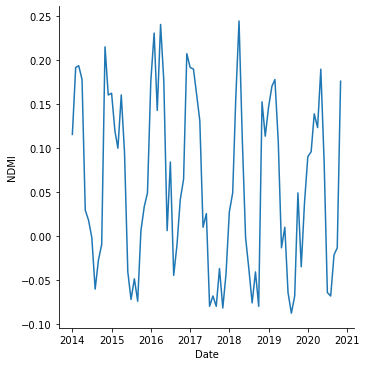

In [401]:
# plot time series
import seaborn as sns
g = sns.relplot(x = "Date",y="NDMI",kind="line",data=df)